# Ensemble Kalman Filter (アンサンブルカルマンフィルター)

## ----------コードを書く前の下準備----------

### Reference (参考文献)
- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．

### Ensemble Kalman Filter (アンサンブルカルマンフィルター)

特徴
- KFでは，平均・共分散行列だけ更新していたが，EnKFでは，アンサンブルメンバー(状態サンプルを幾つも用意しモンテカルロ近似を行う)の更新を考える．
- EnKFでは，非線形・非ガウスにも対応することができる．

対象とする状態空間モデルは，
$$
\begin{align}
x_t=f_t(x_{t-1},v_t),\ v_t\sim q(v_t)\\
y_t=H_tx_t+w_t,\ w_t\sim N(0,R_t)
\end{align}
$$
である．観測モデルに関してはガウス・線形性を仮定するが，非線形の場合でも適切な前処理をすれば適用可能である．

アルゴリズム
1. 初期状態のアンサンブル$\{x_{0|0}^{(i)}\}_{i=1}^N$を生成する．
2. $t=1:T$まで以下を繰り返す．
    1. 一期先予測
        1. システムノイズのアンサンブル$\{v_t^{(i)}\}_{i=1}^N$を$q(v_t)$に従って生成する．
        1. 各アンサンブルメンバーに対して，$x_{t|t-1}^{(i)}=f_t(x_{t-1|t-1}^{(i)},v_t)$を計算する．
    1. フィルタ
        1. 観測ノイズのアンサンブル$\{w_t^{(i)}\}_{i=1}^N$を$N(0,R_t)$に従って生成する．
        1. 共分散行列$\hat V_{t|t-1}$，カルマンゲイン$\hat K_t$を後述する式で計算する．
        1. 各アンサンブルメンバーに対して，$x_{t|t}^{(i)}=x_{t|t-1}^{(i)}+\hat K_t(y_t+\breve w_t^{(i)}-H_tx_{t|t-1}^{(i)})$を計算し，フィルタアンサンブル$\{x_{t|t}^{(i)}\}_{i=1}^N$を得る．

フィルタB.bの計算式は以下の通りである．
$$
\begin{align}
\breve x_{t|t-1}^{(i)}=x_{t|t-1}^{(i)}-\frac{1}{N}\sum_{j=1}^Nx_{t|t-1}^{(j)}\\
\hat V_{t|t-1}=\frac{1}{N-1}\sum_{j=1}^N\breve x_{t|t-1}^{(j)}\breve x_{t|t-1}^{(j)}{}^T\\
\breve w_t^{(i)}=w_t^{(i)}-\frac{1}{N}\sum_{j=1}^Nw_t^{(i)}\\
\hat R_t=\frac{1}{N-1}\sum_{j=1}^N\breve w_t^{(j)}\breve w_t^{(j)}{}^T
\end{align}
$$

### Forced Oscillation with Decay (減衰項付き強制振動)

今回は，淡路他著の5.2節にある減衰項付き強制振動問題を考える．質点$m$の減衰項付き強制振動の支配方程式は以下である．
$$
\begin{align*}
&\frac{dx}{dt}=v\\
&m\frac{dv}{dt}=-kx-rv+w
\end{align*}
$$

ここで，$x$は質点の位置，$v$は速度，$k$は振動定数，$r$は減衰定数，$w$は強制力である．オイラーの前進差分を適用すると，次のように表せる．
$$
\begin{align*}
&x_{t+1}=x_t+\Delta tv_{t-1}\\
&v_{t+1}=-k\frac{\Delta t}{m}x_t+\left(1-r\frac{\Delta t}{m}\right)v_t+\frac{\Delta t}{m}w_t
\end{align*}
$$

今回，パラメータは既知のものとして，$m=1.0, k=0.5, r=0.75, \Delta t=1.0$として双子実験を行う．

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

今回は，真値（完全シミュレーション），シミュレーション値(シミュレーションで使うパラメータ),観測値を次のようにセットアップする．
- 真値：$x_0=5.0, v_0=0.0, w_t=\sin(2\pi t/10)$
- シミュレーション値 : $x_0=6.0, v_0=0.0, w_t=\sin(2\pi t/10)+q,\ q\sim N(0,0.5^2)$
- 観測値 : $y_t=x_t^{true}+\varepsilon,\ \varepsilon\sim N(0, 1)$

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > try_and_error > Python_source : saving place for source
- DataAssimilation > try_and_error > plot : saving place for plot result

バージョンについて
- Mac OS 10.10
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1

In [13]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE

In [4]:
# ハイパーパラメーター
a = -1
b = -2
n_particle = 2**13
obs_sigma = 10**a
sys_sigma = 10**b
mu_0 = 9
sigma_0 = 1
lag = 20

In [11]:
ps = ParticleSmoother(df2, n_particle, obs_sigma, sys_sigma, mu_0, sigma_0, lag)
ps.simulate()

 calculating... t=150/150

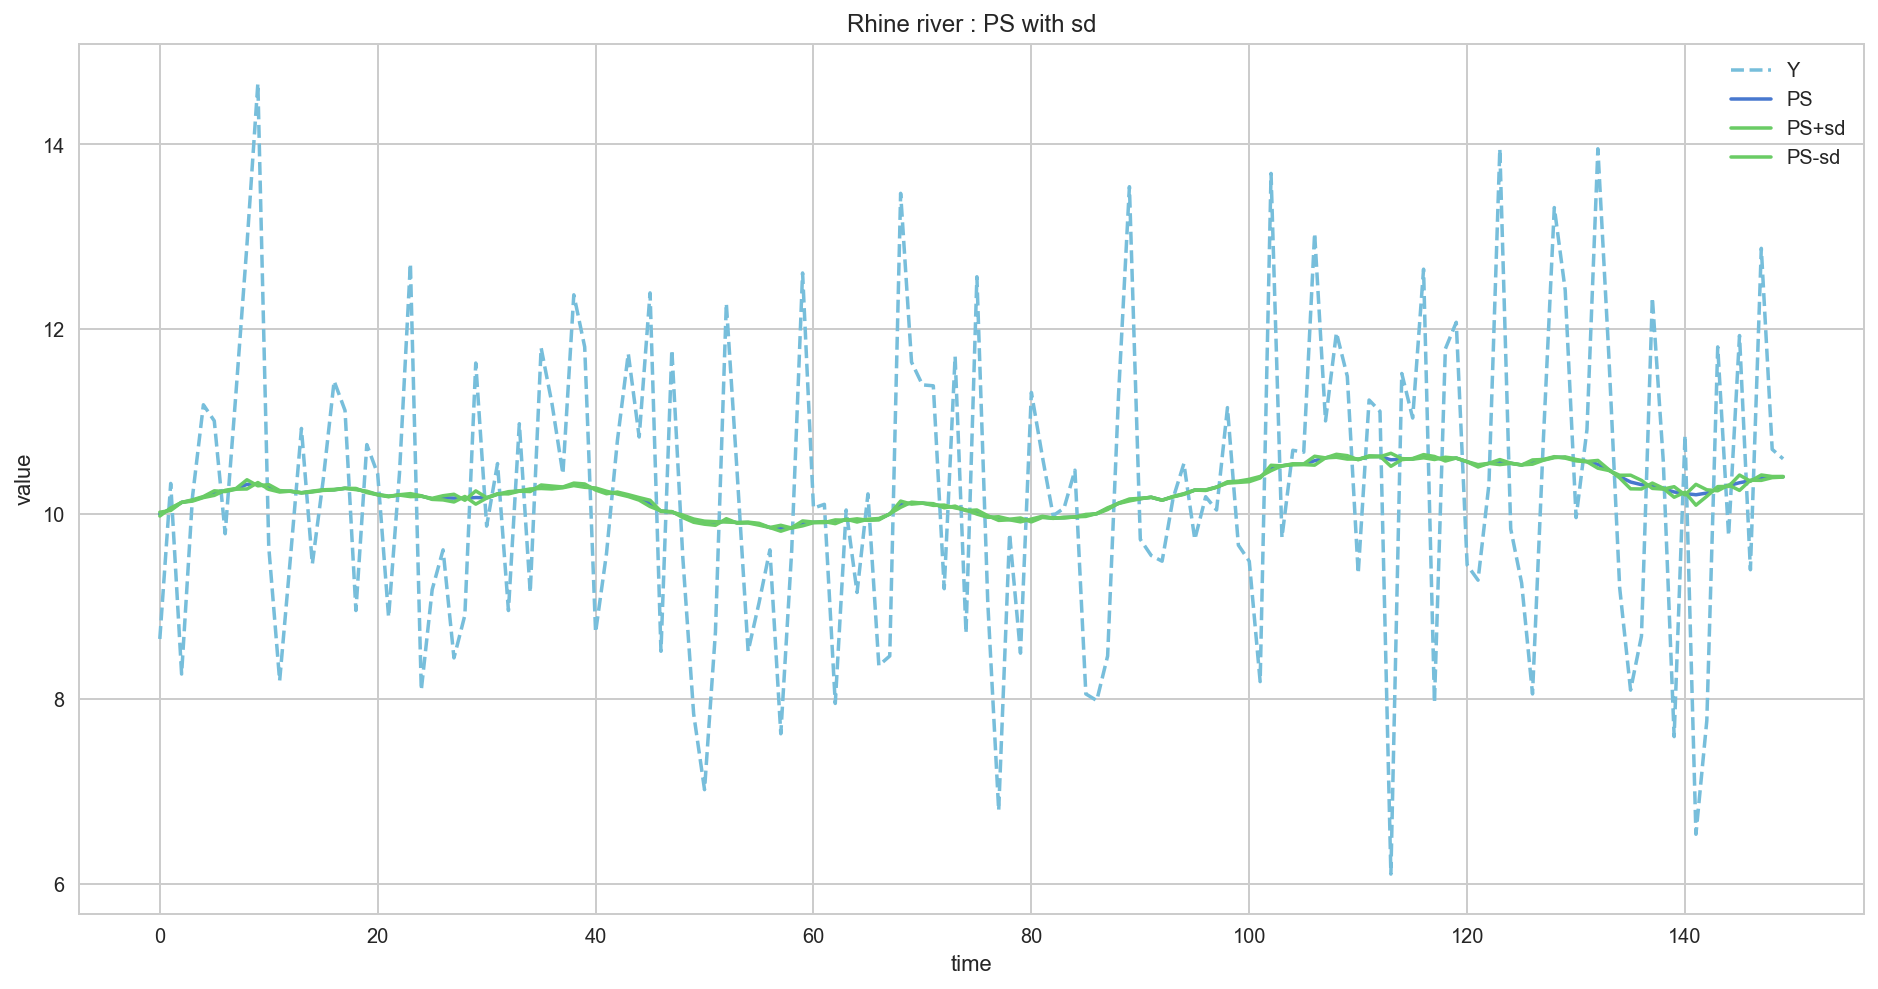

In [23]:
T = len(ps.y)
 
plt.figure(figsize=(16,8))
plt.plot(range(T), ps.y, color = "c", linestyle = "--", label = "Y")
#plt.plot(self.get_filtered_value(), color = "g", label = "PF")
gsv = ps2.get_smoothed_value()
plt.plot(gsv, color = "b", label = "PS")
gssv = ps2.get_smoothed_sd_value()
plt.plot(gsv + gssv, color = "g", label = "PS+sd")
plt.plot(gsv - gssv, color = "g", label = "PS-sd")

plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("Rhine river : PS with sd")
plt.savefig("../plot/171031_particle_smoothing_rhine_withsd.png")

標準偏差取っておきながら，最初に前処理で100で割ってるのでまあ適当なライン

ノイズ発生計算用

In [8]:
q[1]

[0, 1]

In [21]:
def func(a, b):
    return a+b
q = (func, [4,1])
q[0](*q[1])

5

なんか計算用

In [23]:
a = np.zeros((2,3,4))
a[0] = range(4)
a

array([[[ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])